In [1]:
import os
import sys
import random
import numpy as np
import tifffile

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt

2022-11-29 22:53:28.896323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Hyperparameters

In [2]:
## inputs
image_size = 64
#train_path = "/data-nfs/mujiang/data/unet_model_city/Hangzhou"
train_path = "/data-nfs/urban-econ/height_model/sentinel_combo/"
epochs = 100
batch_size = 16
dim = 6

## Seeding

In [3]:
seed = 110
random.seed = seed
np.random.seed = seed
tf.seed = seed

# Image Data Generator

In [4]:
def expand_image(image):
    size = image.shape[0]
    ex_image = np.full((size, size, 4), 0)
    ex_image[:,:,0] = (image == 1)*1
    ex_image[:,:,1] = (image == 2)*1
    ex_image[:,:,2] = (image == 3)*1
    ex_image[:,:,3] = (image == 0)*1
    ex_image = ex_image.astype(np.float32)
    
    return ex_image

In [5]:
class Image_DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path: images and masks folder
        image_path = os.path.join(self.path, id_name, (str(id_name) + "_RS.tif"))
        mask_path = os.path.join(self.path, id_name, (str(id_name) + "_building.png"))
        
        
        ## Reading Images and associated masks
        image = tifffile.imread(image_path)
        #image = cv2.resize(image, (self.image_size, self.image_size))
        
        ## Reading building footprint Masks
        mask = expand_image(cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE))
        #mask = cv2.resize(mask, (self.image_size, self.image_size)) #128x128

        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [6]:
##Ids
data_ids = next(os.walk(train_path))[1]

## Split dataset ids to 80%/10%/10% tran/val/test ratio
train_ids, valid_ids, test_ids = np.split(data_ids, [int(.8 * len(data_ids)), int(.9 * len(data_ids))])

# UNET Architecture

In [7]:
#Convolutional layers in UNnet 
## i. Down sampling
## ii. Bottleneck
## iii. Upsampling

def Unet_down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = BatchNormalization(axis=3)(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def Unet_up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = BatchNormalization(axis=3)(x)
    us = keras.layers.UpSampling2D((2, 2))(c)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def Unet_bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = BatchNormalization(axis=3)(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


In [8]:
# UNet model
def UNet_model():
    size = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, dim))

    p0 = inputs
    c1, p1 = Unet_down_block(p0, size[0]) 
    c2, p2 = Unet_down_block(p1, size[1]) 
    c3, p3 = Unet_down_block(p2, size[2]) 
    c4, p4 = Unet_down_block(p3, size[3]) 


    bn = Unet_bottleneck(p4, size[4])


    u1 = Unet_up_block(bn, c4, size[3]) 
    u2 = Unet_up_block(u1, c3, size[2]) 
    u3 = Unet_up_block(u2, c2, size[1]) 
    u4 = Unet_up_block(u3, c1, size[0])

    outputs = keras.layers.Conv2D(4, 1, activation = 'softmax')(u4)
    model = keras.models.Model(inputs, outputs)
    return model


# Metrics

In [9]:
#f1, recall, precision metics 

def f1_m(y_true, y_pred):
    y_true = y_true[:,:,:,:2] 
    y_pred = y_pred[:,:,:,:2]
    
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def accuracy_fp(y_true, y_pred):
    #copare the last layer, which is the no building layer
    y_true = y_true[:,:,:,-1] 
    y_pred = y_pred[:,:,:,-1]
    
    accuracy = K.mean(K.equal(y_true, K.round(y_pred)))
    return accuracy
    
def recall_m(y_true, y_pred):
        y_true = y_true[:,:,:,:2] 
        y_pred = y_pred[:,:,:,:2]
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def recall_fp(y_true, y_pred):
        #only first 3 classes are buildings
        y_true = y_true[:,:,:,:2] 
        y_pred = y_pred[:,:,:,:2]
        
        true_positives = K.sum(K.max(y_true, axis = 3) * K.max(K.round(K.clip(y_pred, 0, 1)), axis = 3))
        possible_positives = K.sum(K.max(y_true, axis = 3))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
def precision_m(y_true, y_pred):
        y_true = y_true[:,:,:,:2] 
        y_pred = y_pred[:,:,:,:2]
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def precision_fp(y_true, y_pred):
        y_true = y_true[:,:,:,:2] 
        y_pred = y_pred[:,:,:,:2]    
    
        true_positives = K.sum(K.max(y_true, axis = 3) * K.max(K.round(K.clip(y_pred, 0, 1)), axis = 3))
        predicted_positives =  K.sum(K.max(K.round(K.clip(y_pred, 0, 1)), axis = 3))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def d0(y_true, y_pred, smooth=1):
    y_true = y_true[:,:,:,0] 
    y_pred = y_pred[:,:,:,0]
    
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def d1(y_true, y_pred, smooth=1):
    y_true = y_true[:,:,:,1] 
    y_pred = y_pred[:,:,:,1] 
    
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)


def d2(y_true, y_pred, smooth=1):
    y_true = y_true[:,:,:,2] 
    y_pred = y_pred[:,:,:,2]
    
    
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

    
def d3(y_true, y_pred, smooth=1):
    y_true = y_true[:,:,:,3] 
    y_pred = y_pred[:,:,:,3]
    
    
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)    

def partial_dice_coef(y_true, y_pred):
    return -partial_dice_coef_loss(y_true, y_pred)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def partial_dice_coef_loss(y_true, y_pred):
    return -(0.3* (d0(y_true, y_pred, smooth=1) + d1(y_true, y_pred, smooth=1) + d2(y_true, y_pred, smooth=1)) + 0.1*d3(y_true, y_pred, smooth=1))

model = UNet_model()
model.compile(optimizer="adam",loss =  partial_dice_coef_loss, metrics = ["acc",accuracy_fp,f1_m,recall_m,recall_fp,precision_m,precision_fp,partial_dice_coef,d0,d1,d2])
model.summary()


2022-11-29 22:53:38.500339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 22:53:38.916016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22291 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c6:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 6)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 6)   24          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   880         ['batch_normalization[0][0]']    
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 16)   2320        ['conv2d[0][0]']             

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32, 32, 32)  128         ['conv2d_15[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 64, 64, 32)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 concatenate_3 (Concatenate)    (None, 64, 64, 48)   0           ['up_sampling2d_3[0][0]',        
                                                                  'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 16)   6928        ['concatenate_3[0][0]']          
          

# Callbacks

In [10]:
#Save the best model
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]
name_weights = "model_weights/" + "Final_best_combo"  +"_weights.h5"
callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)

# Model Training

In [11]:
#generating train, test, validation datasets
train_gen = Image_DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = Image_DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
test_gen = Image_DataGen(test_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size



In [12]:
history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs,callbacks=callbacks,shuffle=True)

Epoch 1/100


/tmp/ipykernel_285083/4060983979.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs,callbacks=callbacks,shuffle=True)
2022-11-29 22:53:42.209274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-11-29 22:53:43.199349: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-29 22:53:43.199566: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-29 22:53:43.199593: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-29 22:53:43.199917: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot s

858/858 [==============================] - 86s 94ms/step - loss: -0.2799 - acc: 0.6464 - accuracy_fp: 0.7006 - f1_m: 0.2330 - recall_m: 0.3378 - recall_fp: 0.5365 - precision_m: 0.1862 - precision_fp: 0.2962 - partial_dice_coef: 0.2868 - d0: 0.1569 - d1: 0.2160 - d2: 0.3208 - val_loss: -0.3109 - val_acc: 0.6884 - val_accuracy_fp: 0.7340 - val_f1_m: 0.2718 - val_recall_m: 0.3761 - val_recall_fp: 0.5645 - val_precision_m: 0.2139 - val_precision_fp: 0.3208 - val_partial_dice_coef: 0.3109 - val_d0: 0.1678 - val_d1: 0.2438 - val_d2: 0.3534 - lr: 0.0010
Epoch 2/100
858/858 [==============================] - 14s 16ms/step - loss: -0.3079 - acc: 0.6875 - accuracy_fp: 0.7344 - f1_m: 0.2513 - recall_m: 0.3621 - recall_fp: 0.5699 - precision_m: 0.2024 - precision_fp: 0.3181 - partial_dice_coef: 0.3079 - d0: 0.1751 - d1: 0.2421 - d2: 0.3365 - val_loss: -0.3115 - val_acc: 0.7184 - val_accuracy_fp: 0.7594 - val_f1_m: 0.2757 - val_recall_m: 0.3439 - val_recall_fp: 0.5125 - val_precision_m: 0.2375 - v

858/858 [==============================] - 12s 14ms/step - loss: -0.3184 - acc: 0.7160 - accuracy_fp: 0.7604 - f1_m: 0.2785 - recall_m: 0.3810 - recall_fp: 0.5826 - precision_m: 0.2298 - precision_fp: 0.3522 - partial_dice_coef: 0.3184 - d0: 0.1904 - d1: 0.2676 - d2: 0.3235 - val_loss: -0.3229 - val_acc: 0.7281 - val_accuracy_fp: 0.7664 - val_f1_m: 0.3070 - val_recall_m: 0.3843 - val_recall_fp: 0.5465 - val_precision_m: 0.2634 - val_precision_fp: 0.3735 - val_partial_dice_coef: 0.3229 - val_d0: 0.1965 - val_d1: 0.2725 - val_d2: 0.3276 - lr: 0.0010
Epoch 16/100
858/858 [==============================] - 13s 15ms/step - loss: -0.3284 - acc: 0.7051 - accuracy_fp: 0.7481 - f1_m: 0.2794 - recall_m: 0.3881 - recall_fp: 0.5835 - precision_m: 0.2280 - precision_fp: 0.3444 - partial_dice_coef: 0.3284 - d0: 0.2019 - d1: 0.2605 - d2: 0.3559 - val_loss: -0.3238 - val_acc: 0.7153 - val_accuracy_fp: 0.7549 - val_f1_m: 0.3002 - val_recall_m: 0.3883 - val_recall_fp: 0.5671 - val_precision_m: 0.2510 - 

Epoch 29/100
858/858 [==============================] - 12s 14ms/step - loss: -0.3315 - acc: 0.7049 - accuracy_fp: 0.7479 - f1_m: 0.2906 - recall_m: 0.4123 - recall_fp: 0.6110 - precision_m: 0.2335 - precision_fp: 0.3482 - partial_dice_coef: 0.3315 - d0: 0.1983 - d1: 0.2881 - d2: 0.3422 - val_loss: -0.3295 - val_acc: 0.7164 - val_accuracy_fp: 0.7571 - val_f1_m: 0.3136 - val_recall_m: 0.4138 - val_recall_fp: 0.5940 - val_precision_m: 0.2584 - val_precision_fp: 0.3707 - val_partial_dice_coef: 0.3295 - val_d0: 0.2152 - val_d1: 0.2789 - val_d2: 0.3276 - lr: 1.0000e-04
Epoch 30/100
858/858 [==============================] - 11s 13ms/step - loss: -0.3361 - acc: 0.7114 - accuracy_fp: 0.7540 - f1_m: 0.2882 - recall_m: 0.3988 - recall_fp: 0.6014 - precision_m: 0.2354 - precision_fp: 0.3557 - partial_dice_coef: 0.3361 - d0: 0.2042 - d1: 0.2703 - d2: 0.3679 - val_loss: -0.3294 - val_acc: 0.7221 - val_accuracy_fp: 0.7623 - val_f1_m: 0.3111 - val_recall_m: 0.4008 - val_recall_fp: 0.5793 - val_preci

858/858 [==============================] - 16s 19ms/step - loss: -0.3410 - acc: 0.7179 - accuracy_fp: 0.7596 - f1_m: 0.3008 - recall_m: 0.4062 - recall_fp: 0.5998 - precision_m: 0.2481 - precision_fp: 0.3666 - partial_dice_coef: 0.3410 - d0: 0.2084 - d1: 0.2870 - d2: 0.3617 - val_loss: -0.3333 - val_acc: 0.7242 - val_accuracy_fp: 0.7641 - val_f1_m: 0.3178 - val_recall_m: 0.4095 - val_recall_fp: 0.5878 - val_precision_m: 0.2662 - val_precision_fp: 0.3816 - val_partial_dice_coef: 0.3333 - val_d0: 0.2190 - val_d1: 0.2855 - val_d2: 0.3276 - lr: 1.0000e-04
Epoch 44/100
858/858 [==============================] - 14s 16ms/step - loss: -0.3289 - acc: 0.7152 - accuracy_fp: 0.7587 - f1_m: 0.2945 - recall_m: 0.4056 - recall_fp: 0.6060 - precision_m: 0.2401 - precision_fp: 0.3604 - partial_dice_coef: 0.3289 - d0: 0.2028 - d1: 0.2851 - d2: 0.3296 - val_loss: -0.3331 - val_acc: 0.7233 - val_accuracy_fp: 0.7642 - val_f1_m: 0.3156 - val_recall_m: 0.4077 - val_recall_fp: 0.5899 - val_precision_m: 0.263

Epoch 57/100
858/858 [==============================] - 15s 17ms/step - loss: -0.3325 - acc: 0.7189 - accuracy_fp: 0.7602 - f1_m: 0.2959 - recall_m: 0.4031 - recall_fp: 0.5980 - precision_m: 0.2435 - precision_fp: 0.3606 - partial_dice_coef: 0.3325 - d0: 0.2069 - d1: 0.2848 - d2: 0.3370 - val_loss: -0.3326 - val_acc: 0.7277 - val_accuracy_fp: 0.7676 - val_f1_m: 0.3175 - val_recall_m: 0.4044 - val_recall_fp: 0.5816 - val_precision_m: 0.2680 - val_precision_fp: 0.3851 - val_partial_dice_coef: 0.3326 - val_d0: 0.2181 - val_d1: 0.2832 - val_d2: 0.3276 - lr: 1.0000e-05
Epoch 58/100
858/858 [==============================] - 17s 19ms/step - loss: -0.3332 - acc: 0.7226 - accuracy_fp: 0.7644 - f1_m: 0.2993 - recall_m: 0.4062 - recall_fp: 0.6007 - precision_m: 0.2472 - precision_fp: 0.3674 - partial_dice_coef: 0.3332 - d0: 0.2058 - d1: 0.2883 - d2: 0.3358 - val_loss: -0.3329 - val_acc: 0.7230 - val_accuracy_fp: 0.7637 - val_f1_m: 0.3175 - val_recall_m: 0.4115 - val_recall_fp: 0.5931 - val_preci

856/858 [============================>.] - ETA: 0s - loss: -0.3366 - acc: 0.7174 - accuracy_fp: 0.7596 - f1_m: 0.3022 - recall_m: 0.4094 - recall_fp: 0.6015 - precision_m: 0.2495 - precision_fp: 0.3684 - partial_dice_coef: 0.3366 - d0: 0.2076 - d1: 0.2981 - d2: 0.3372
Epoch 71: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
858/858 [==============================] - 14s 16ms/step - loss: -0.3367 - acc: 0.7174 - accuracy_fp: 0.7595 - f1_m: 0.3021 - recall_m: 0.4092 - recall_fp: 0.6010 - precision_m: 0.2494 - precision_fp: 0.3682 - partial_dice_coef: 0.3367 - d0: 0.2076 - d1: 0.2979 - d2: 0.3376 - val_loss: -0.3333 - val_acc: 0.7286 - val_accuracy_fp: 0.7681 - val_f1_m: 0.3186 - val_recall_m: 0.4046 - val_recall_fp: 0.5812 - val_precision_m: 0.2693 - val_precision_fp: 0.3863 - val_partial_dice_coef: 0.3333 - val_d0: 0.2165 - val_d1: 0.2869 - val_d2: 0.3276 - lr: 1.0000e-05
Epoch 72/100
858/858 [==============================] - 13s 16ms/step - loss: -0.3421 - acc: 0.

Epoch 85/100
858/858 [==============================] - 14s 16ms/step - loss: -0.3383 - acc: 0.7156 - accuracy_fp: 0.7586 - f1_m: 0.2963 - recall_m: 0.3988 - recall_fp: 0.5997 - precision_m: 0.2446 - precision_fp: 0.3701 - partial_dice_coef: 0.3383 - d0: 0.2081 - d1: 0.2823 - d2: 0.3582 - val_loss: -0.3335 - val_acc: 0.7225 - val_accuracy_fp: 0.7632 - val_f1_m: 0.3187 - val_recall_m: 0.4142 - val_recall_fp: 0.5962 - val_precision_m: 0.2651 - val_precision_fp: 0.3810 - val_partial_dice_coef: 0.3335 - val_d0: 0.2196 - val_d1: 0.2862 - val_d2: 0.3276 - lr: 1.0000e-06
Epoch 86/100
858/858 [==============================] - 14s 17ms/step - loss: -0.3401 - acc: 0.7212 - accuracy_fp: 0.7637 - f1_m: 0.3038 - recall_m: 0.4092 - recall_fp: 0.6040 - precision_m: 0.2514 - precision_fp: 0.3736 - partial_dice_coef: 0.3401 - d0: 0.2106 - d1: 0.2888 - d2: 0.3542 - val_loss: -0.3335 - val_acc: 0.7246 - val_accuracy_fp: 0.7649 - val_f1_m: 0.3186 - val_recall_m: 0.4110 - val_recall_fp: 0.5912 - val_preci

858/858 [==============================] - 16s 18ms/step - loss: -0.3366 - acc: 0.7199 - accuracy_fp: 0.7615 - f1_m: 0.3049 - recall_m: 0.4134 - recall_fp: 0.6071 - precision_m: 0.2506 - precision_fp: 0.3691 - partial_dice_coef: 0.3366 - d0: 0.2058 - d1: 0.3002 - d2: 0.3364 - val_loss: -0.3332 - val_acc: 0.7234 - val_accuracy_fp: 0.7641 - val_f1_m: 0.3174 - val_recall_m: 0.4109 - val_recall_fp: 0.5930 - val_precision_m: 0.2648 - val_precision_fp: 0.3819 - val_partial_dice_coef: 0.3332 - val_d0: 0.2204 - val_d1: 0.2839 - val_d2: 0.3276 - lr: 1.0000e-08
Epoch 99/100
858/858 [==============================] - 14s 16ms/step - loss: -0.3346 - acc: 0.7183 - accuracy_fp: 0.7601 - f1_m: 0.2982 - recall_m: 0.4041 - recall_fp: 0.5993 - precision_m: 0.2465 - precision_fp: 0.3667 - partial_dice_coef: 0.3346 - d0: 0.2089 - d1: 0.2866 - d2: 0.3404 - val_loss: -0.3334 - val_acc: 0.7235 - val_accuracy_fp: 0.7643 - val_f1_m: 0.3183 - val_recall_m: 0.4125 - val_recall_fp: 0.5943 - val_precision_m: 0.265

In [1]:
(24+14+11+11+11+11+10+10)/8

12.75

In [24]:
# Load the best model
model.load_weights(name_weights)

# model evaluation

In [ ]:
#evaluation with metrics
g=Image_DataGen(test_ids, train_path, batch_size=len(test_ids), image_size=image_size)
x=[]
y=[]
for i in test_ids:
    x_test,y_test=g.__load__(i)
    x.append(x_test)
    y.append(y_test)

x=np.asarray(x)
y=np.asarray(y) 
#model evaluation
model.evaluate(x,y,verbose=1),print(model.metrics_names)

In [26]:
#loss =  dice_coef_loss, metrics = dice_coef
hist=history
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
dice_coef=hist.history['partial_dice_coef']
val_dice_coef=hist.history['val_partial_dice_coef']

xc=range(epochs)

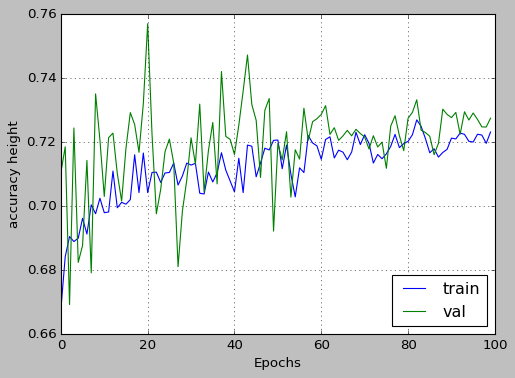

In [36]:
#Plot train,val accuracy of height prediction

accuracy_fp = hist.history['acc']
val_accuracy_fp = hist.history['val_acc']

plt.figure(1,figsize=(7,5))
plt.plot(xc,accuracy_fp)
plt.plot(xc,val_accuracy_fp)
plt.xlabel('Epochs')
plt.ylabel('accuracy height')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('recall_fp.png')

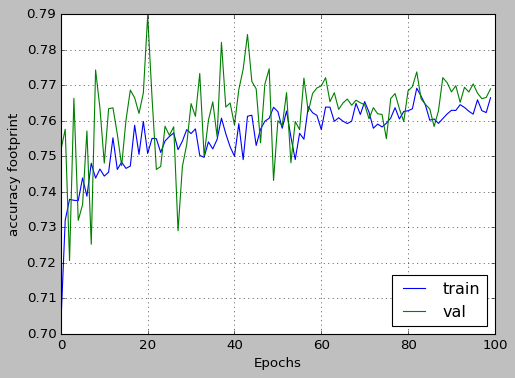

In [33]:
#Plot train,val accuracy of footprint prediction

accuracy_fp = hist.history['accuracy_fp']
val_accuracy_fp = hist.history['val_accuracy_fp']

plt.figure(1,figsize=(7,5))
plt.plot(xc,accuracy_fp)
plt.plot(xc,val_accuracy_fp)
plt.xlabel('Epochs')
plt.ylabel('accuracy footprint')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('recall_fp.png')

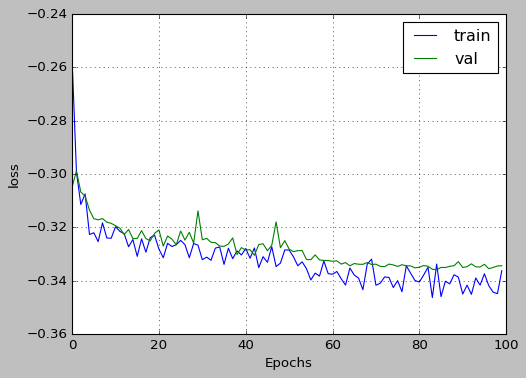

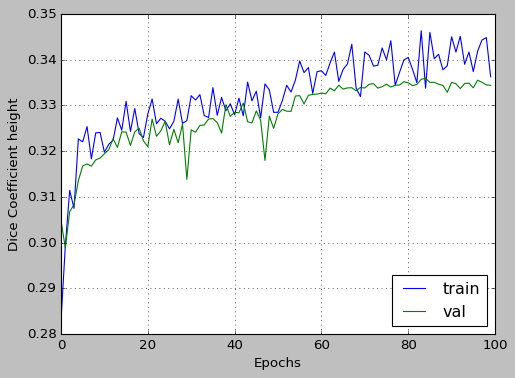

In [37]:
#Plot train,val loss
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])
#plt.savefig('loss.png')


#Plot train,val dice coefficients
plt.figure(1,figsize=(7,5))
plt.plot(xc,dice_coef)
plt.plot(xc,val_dice_coef)
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient height')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('dice.png')

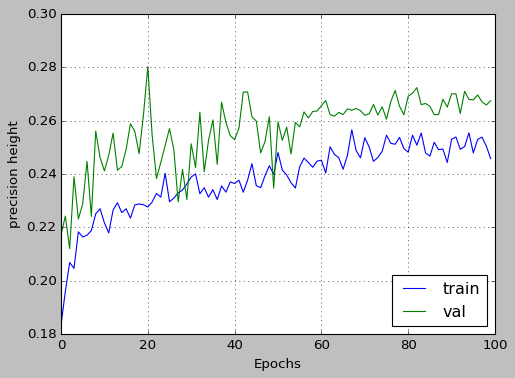

In [43]:
#Plot train,val recall

precision_m = hist.history['precision_m']
val_precision_m = hist.history['val_precision_m']

plt.figure(1,figsize=(7,5))
plt.plot(xc,precision_m)
plt.plot(xc,val_precision_m)
plt.xlabel('Epochs')
plt.ylabel('precision height')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('recall_m.png')

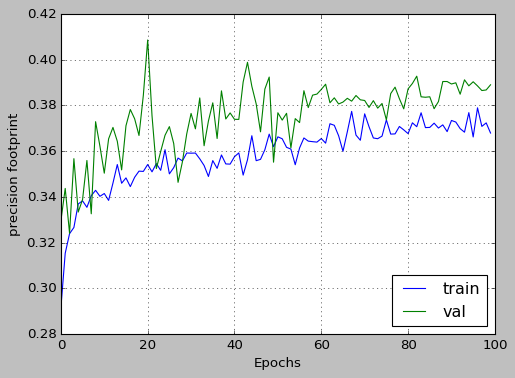

In [45]:
#Plot train,val recall

precision_fp = hist.history['precision_fp']
val_precision_fp = hist.history['val_precision_fp']

plt.figure(1,figsize=(7,5))
plt.plot(xc,precision_fp)
plt.plot(xc,val_precision_fp)
plt.xlabel('Epochs')
plt.ylabel('precision footprint')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('recall_m.png')

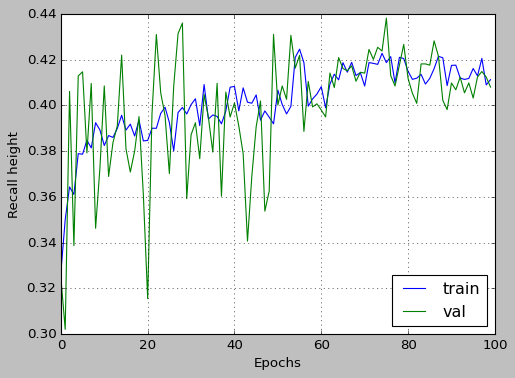

<Figure size 640x480 with 0 Axes>

In [29]:
#Plot train,val recall

recall_m = hist.history['recall_m']
val_recall_m = hist.history['val_recall_m']

plt.figure(1,figsize=(7,5))
plt.plot(xc,recall_m)
plt.plot(xc,val_recall_m)
plt.xlabel('Epochs')
plt.ylabel('Recall height')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('recall_m.png')

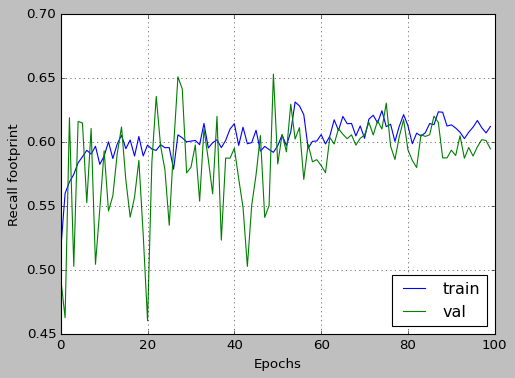

<Figure size 640x480 with 0 Axes>

In [30]:
#Plot train,val recall of footprint pre4diction

recall_fp = hist.history['recall_fp']
val_recall_fp = hist.history['val_recall_fp']

plt.figure(1,figsize=(7,5))
plt.plot(xc,recall_fp)
plt.plot(xc,val_recall_fp)
plt.xlabel('Epochs')
plt.ylabel('Recall footprint')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('recall_fp.png')

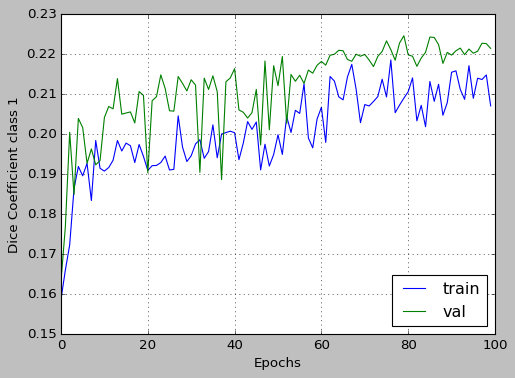

In [39]:
#Plot train,val dice coefficients

dice_0_coef=hist.history['d0']
val_dice_0_coef=hist.history['val_d0']

plt.figure(1,figsize=(7,5))
plt.plot(xc,dice_0_coef)
plt.plot(xc,val_dice_0_coef)
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient class 1')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('dice.png')

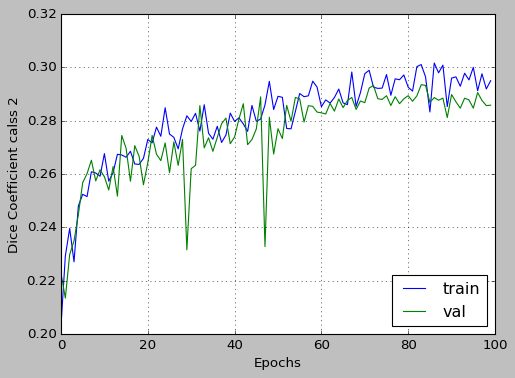

In [41]:
#Plot train,val dice coefficients

dice_1_coef=hist.history['d1']
val_dice_1_coef=hist.history['val_d1']

plt.figure(1,figsize=(7,5))
plt.plot(xc,dice_1_coef)
plt.plot(xc,val_dice_1_coef)
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient calss 2')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('dice.png')

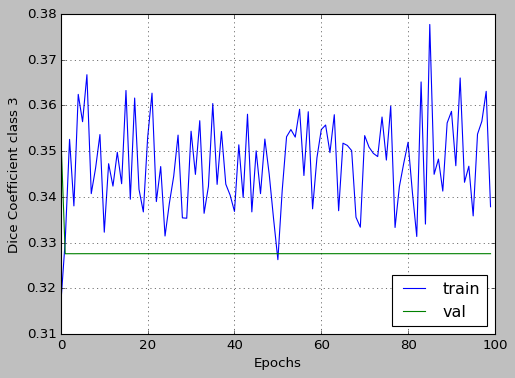

In [42]:
#Plot train,val dice coefficients

dice_2_coef=hist.history['d2']
val_dice_2_coef=hist.history['val_d2']

plt.figure(1,figsize=(7,5))
plt.plot(xc,dice_2_coef)
plt.plot(xc,val_dice_2_coef)
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient class 3')
plt.grid(True)
plt.legend(['train','val'],loc='lower right')
plt.style.use(['classic'])
plt.show()
#plt.savefig('dice.png')